In [804]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

# Assignment 2 - Regression
### Predict the TOTAL COMPENSATION for this year. 

The data file provided is a salary survey for tech workers in Europe. We want to predict the total amount of compensation they bring in each year, based off of the details of their work. 

Some notes that will be important:
<ul>
    <li>The total compensation will need to be constructed, there is a column for salary, "Yearly brutto salary (without bonus and stocks) in EUR", as well as a column for bonus compensation, "Yearly bonus + stocks in EUR". 
    <li>Some categorical variables will need some work, and there isn't generally an exact answer. The main concern is things with categories that have a bunch of values with a very small count. For example, if there is only 1 person in City X, then that value likely needs to be addressed. We don't want it encoded into a new column of one 1 and thousands of 0s. 
    <li>There is an article exploring some of the data here: https://www.asdcode.de/2021/01/it-salary-survey-december-2020.html
    <li>Imputation and a bit of data manipulation will be required. 
    <li>Use any regression method you'd like. Some ones are closely related to what we've done, you may want to look at them, e.g. ExtraTreesRegressor. 
    <li>Initial accurracy, and potentially final accuracy, may not be great. When I made a plain model will little optimization the errors were large and the R2 was low. There is lots of room for optimization. 
    <li>Research challenge - try some work on the target, look into TransformedTargetRegressor and see if that helps. Recall in stats when we had skewed distributions... Maybe it helps, maybe it doesn't. 
    <li>EDA and data prep are up to you - you'll probably need to do a little exploring to figure out what cleanup is needed. When I did it, I did things kind of iteratively when I did it. For example, look at the value counts, figure out how to treat the different categories, clean something up, look at the results, potentially repeat if needed. After you figure out what needs to be done, you may be able to take some of those steps and incorporate them into a pipeline to be cleaner....
    <li><b>CRITICAL - Please make sure your code runs with RUN ALL. It should load the data that you're given, do all the processing, and spit out results. Comment out or remove anything that you've cleaned up and don't need - e.g. if you scaled a value manually, then moved that into a pipeline, don't leave the original scaling code active when the file is run.</b>
</ul>

### Details and Deliverables

You'll need to build code to produce the predictions. In particular, there's a few things that'll be marked:
<ul>
    <li>Please add a markdown cell at the bottom, and put in a few notes addressing the following:
    <ul>
        <li> Accuracy of your models with/without feature selection. Include both train/test for each. Please use R2 and RMSE. 
        <li> Feature Selection - Please identify what you did for feature selection. No need for a long explaination, something along the lines of "I did X, and the result was that 4 features were removed". Try at least 2 things. 
        <li> Hyperparameter Changes / Grid Search Improvements. What did you try, and why. Similar explaination to above, short. 
        <li> Overall this section should be roughly as long as this intro block - just outline what the results were, what you did to improve, and the results after. 
        <li> If you could use titles/bullet points I'd really appreciate it. 
    </ul>
    <li>Grade Breakdown:
    <ul>
        <li> Code is readable, there are comments: 20%
        <li> Explaination as defined above: 60% (20% each point)
        <li> Accuracy: 20% As compared to everyone else. This will be generously graded, I won't be surprised if overall accuracy is low for most people. 
    </ul>
</ul>

In [805]:
#Load Data
df = pd.read_csv("data/Euro_Salary.csv")
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Timestamp,1253,1248,24/11/2020 13:55:19,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,1226.0,NaN,NaN,NaN,32.509788,5.663804,20.0,29.0,32.0,35.0,69.0
Gender,1243,3,Male,1049,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City,1253,119,Berlin,681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Position,1247,148,Software Engineer,387,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total years of experience,1237,48,10,138,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Years of experience in Germany,1221,53,2,195,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Seniority level,1241,24,Senior,565,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Your main technology / programming language,1126,256,Java,184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Other technologies/programming languages you use often,1096,562,Javascript / Typescript,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [806]:
df.sample(10)

,Timestamp,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type
969,30/11/2020 15:10:35,35.0,Male,Berlin,Software Engineer,2,2,Middle,"python, scala","Python, Java / Scala, SQL, AWS, Docker",50000.0,500,45,Full-time employee,Unlimited contract,English,1000+,Product
489,25/11/2020 08:47:15,27.0,Male,Berlin,Software Engineer,6,3,Middle,Java,"C/C++, Kubernetes, Docker",82000.0,12000,30,Full-time employee,Unlimited contract,English,1000+,Product
661,25/11/2020 18:15:28,32.0,Female,Munich,QA Engineer,9,9,Middle,NaN,NaN,60000.0,NaN,30,Full-time employee,Unlimited contract,German,101-1000,Product
768,26/11/2020 13:35:07,30.0,Male,Berlin,DevOps,7,3,Middle,NaN,NaN,80000.0,NaN,30,Full-time employee,Unlimited contract,English,1000+,Startup
1168,17/12/2020 10:28:18,40.0,Male,Berlin,Data Engineer,14,0,Middle,"BI, DWH, ETL/ELT","Python, SQL, MS SQL Stack, Oracle, Informatica...",57000.0,3000,24,Full-time employee,Unlimited contract,English,101-1000,Product
47,24/11/2020 11:31:45,32.0,Male,Berlin,Backend Developer,3,1,Middle,Java,"AWS, Kubernetes, Docker",77000.0,NaN,30,Full-time employee,Unlimited contract,English,101-1000,Product
966,30/11/2020 14:36:32,35.0,Male,Berlin,Data Engineer,6,6,Senior,Java,"Python, Java / Scala, SQL, Go, AWS, Kubernetes...",200000.0,200000,14,Self-employed (freelancer),Temporary contract,English,11-50,Startup
827,27/11/2020 12:05:25,27.0,Male,Berlin,Data Scientist,5,1,Middle,Python,SQL,55000.0,0,24,Full-time employee,Unlimited contract,English,51-100,Product
708,25/11/2020 22:18:59,NaN,Male,Frankfurt,Software Engineer,18,1,Senior,NaN,"Javascript / Typescript, .NET, SQL, Google Cloud",81000.0,3375,30,Full-time employee,Unlimited contract,English,1000+,Product
921,30/11/2020 10:49:42,36.0,Male,Nuremberg,Software Engineer,20,20,Lead,Java,"Java / Scala, SQL, Kubernetes, Docker",74000.0,6000,28,Full-time employee,Unlimited contract,German,1000+,Finance


In [807]:
#df.info()
df["Other technologies/programming languages you use often"].value_counts()

Javascript / Typescript                                                                   44
Python                                                                                    37
SQL                                                                                       31
AWS, Docker                                                                               16
Kotlin                                                                                    15
                                                                                          ..
Python, Ruby, Java / Scala, Go, Rust, AWS, Kubernetes, Docker, Terraform, helm, packer     1
Kotlin, SQL, AWS, Kubernetes, Docker                                                       1
Python, R, Go                                                                              1
C/C++, PHP, SQL                                                                            1
Python, AWS, Kubernetes, Docker, terraform, ansible                   

In [808]:
df.head()

,Timestamp,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type
0,24/11/2020 11:14:15,26.0,Male,Munich,Software Engineer,5,3,Senior,TypeScript,"Kotlin, Javascript / Typescript",80000.0,5000,30,Full-time employee,Unlimited contract,English,51-100,Product
1,24/11/2020 11:14:16,26.0,Male,Berlin,Backend Developer,7,4,Senior,Ruby,NaN,80000.0,NaN,28,Full-time employee,Unlimited contract,English,101-1000,Product
2,24/11/2020 11:14:21,29.0,Male,Berlin,Software Engineer,12,6,Lead,Javascript / Typescript,"Javascript / Typescript, Docker",120000.0,120000,30,Self-employed (freelancer),Temporary contract,English,101-1000,Product
3,24/11/2020 11:15:24,28.0,Male,Berlin,Frontend Developer,4,1,Junior,Javascript,NaN,54000.0,NaN,24,Full-time employee,Unlimited contract,English,51-100,Startup
4,24/11/2020 11:15:46,37.0,Male,Berlin,Backend Developer,17,6,Senior,C# .NET,".NET, SQL, AWS, Docker",62000.0,NaN,29,Full-time employee,Unlimited contract,English,101-1000,Product


# Answers and Explainations
(Expand/modify as needed)

### Results

### Feature Selection Activities

### Hyperparameter Changes

In [809]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 18 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Timestamp                                               1253 non-null   object 
 1   Age                                                     1226 non-null   float64
 2   Gender                                                  1243 non-null   object 
 3   City                                                    1253 non-null   object 
 4   Position                                                1247 non-null   object 
 5   Total years of experience                               1237 non-null   object 
 6   Years of experience in Germany                          1221 non-null   object 
 7   Seniority level                                         1241 non-null   object 
 8   Your main technology / programming lan

In [810]:
# Check for nulls
df.isnull().sum().sort_values()

Timestamp                                                   0
City                                                        0
Yearly brutto salary (without bonus and stocks) in EUR      0
Position                                                    6
Gender                                                     10
Seniority level                                            12
Main language at work                                      16
Total years of experience                                  16
Employment status                                          17
Company size                                               18
Company type                                               25
Age                                                        27
Сontract duration                                          29
Years of experience in Germany                             32
Number of vacation days                                    68
Your main technology / programming language               127
Other te

In [811]:
# Combinding columns and changing dtypes
df["Bonus"] = pd.to_numeric(df["Yearly bonus + stocks in EUR"], downcast="float", errors="coerce")
df["Bonus"].fillna(0, inplace=True)
df["target"] = df["Yearly brutto salary (without bonus and stocks) in EUR"] + df["Bonus"]
df.drop(columns={"Timestamp","Yearly brutto salary (without bonus and stocks) in EUR", "Yearly bonus + stocks in EUR", "Bonus"}, inplace=True)
df['Total years of experience'] = pd.to_numeric(df['Total years of experience'], downcast="float", errors='coerce')
df['Years of experience in Germany'] = pd.to_numeric(df['Years of experience in Germany'], downcast="float", errors='coerce')
df['Number of vacation days'] = pd.to_numeric(df['Number of vacation days'], downcast="float", errors='coerce')




In [812]:
df["Your main technology / programming language"].value_counts()

Java                 184
Python               164
PHP                   56
C++                   38
JavaScript            34
                    ... 
Go, PHP, SQL           1
Kotlin                 1
Jira                   1
Qml                    1
consumer analysis      1
Name: Your main technology / programming language, Length: 256, dtype: int64

In [813]:
df["Other technologies/programming languages you use often"].value_counts()

Javascript / Typescript                                                                   44
Python                                                                                    37
SQL                                                                                       31
AWS, Docker                                                                               16
Kotlin                                                                                    15
                                                                                          ..
Python, Ruby, Java / Scala, Go, Rust, AWS, Kubernetes, Docker, Terraform, helm, packer     1
Kotlin, SQL, AWS, Kubernetes, Docker                                                       1
Python, R, Go                                                                              1
C/C++, PHP, SQL                                                                            1
Python, AWS, Kubernetes, Docker, terraform, ansible                   

In [814]:
df["Number of vacation days"].value_counts()

30.0     488
28.0     233
27.0     102
25.0      91
26.0      71
24.0      67
29.0      24
20.0      13
21.0      10
31.0       8
32.0       8
22.0       8
35.0       5
36.0       5
0.0        4
40.0       4
23.0       4
45.0       3
14.0       3
33.0       3
15.0       2
12.0       2
365.0      1
38.0       1
16.0       1
3.0        1
60.0       1
50.0       1
99.0       1
37.5       1
1.0        1
5.0        1
37.0       1
39.0       1
34.0       1
10.0       1
Name: Number of vacation days, dtype: int64

In [815]:
df["Years of experience in Germany"].value_counts()

2.00     195
1.00     189
3.00     155
5.00     142
4.00     122
0.00      99
6.00      70
7.00      37
10.00     29
1.50      24
9.00      20
8.00      17
0.50      13
12.00     12
2.50      10
3.50       9
15.00      8
20.00      7
11.00      7
14.00      5
13.00      4
30.00      3
19.00      2
0.25       2
18.00      2
0.90       1
25.00      1
0.80       1
16.00      1
17.00      1
0.40       1
26.00      1
4.50       1
0.10       1
2.60       1
0.20       1
Name: Years of experience in Germany, dtype: int64

In [816]:
df["Сontract duration"].value_counts()

Unlimited contract    1159
Temporary contract      64
0                        1
Name: Сontract duration, dtype: int64

In [817]:
df["Age"].value_counts()


30.0    110
33.0     94
32.0     94
28.0     87
31.0     87
29.0     86
35.0     82
34.0     74
36.0     60
26.0     59
27.0     58
38.0     48
37.0     44
25.0     42
40.0     31
24.0     28
39.0     28
42.0     20
41.0     14
23.0     12
45.0     11
43.0     10
22.0      8
44.0      8
46.0      8
48.0      4
47.0      3
56.0      2
49.0      2
54.0      2
66.0      1
53.0      1
65.0      1
59.0      1
50.0      1
51.0      1
21.0      1
20.0      1
69.0      1
52.0      1
Name: Age, dtype: int64

In [818]:
df["Company type"].value_counts()

Product                760
Startup                252
Consulting / Agency    142
Bank                     5
Media                    3
                      ... 
Publisher                1
Energy                   1
Enterprise               1
service                  1
eCommerce                1
Name: Company type, Length: 63, dtype: int64

In [819]:
df["Company size"].value_counts()

1000+       448
101-1000    405
11-50       174
51-100      147
up to 10     61
Name: Company size, dtype: int64

In [820]:
df["Employment status"].value_counts()

Full-time employee                                                                 1190
Self-employed (freelancer)                                                           28
Part-time employee                                                                    8
Founder                                                                               3
Company Director                                                                      1
working student                                                                       1
Working Student                                                                       1
Full-time position, part-time position, & self-employed (freelancing, tutoring)       1
Intern                                                                                1
full-time, but 32 hours per week (it was my request, I'm a student)                   1
Werkstudent                                                                           1
Name: Employment status, dtype: 

In [821]:
df["Total years of experience"].value_counts()

10.0     138
5.0      136
6.0       99
8.0       92
7.0       84
4.0       80
12.0      67
3.0       66
15.0      63
9.0       60
2.0       57
11.0      43
13.0      41
14.0      39
1.0       31
20.0      28
16.0      20
18.0      16
17.0      12
19.0       7
25.0       7
0.0        6
22.0       5
30.0       4
2.5        4
21.0       3
23.0       2
27.0       2
4.5        2
3.5        2
1.5        2
0.8        2
6.5        1
26.0       1
28.0       1
29.0       1
24.0       1
5.5        1
40.0       1
31.0       1
383.0      1
7.5        1
Name: Total years of experience, dtype: int64

In [822]:
df["Main language at work"].value_counts()

English               1020
German                 186
Russian                 12
Italian                  3
Spanish                  3
English and German       2
Polish                   2
Русский                  2
Czech                    2
50/50                    1
Deuglisch                1
French                   1
both                     1
Russian, English         1
Name: Main language at work, dtype: int64

In [823]:
df["Seniority level"].value_counts()

Senior                                       565
Middle                                       366
Lead                                         166
Junior                                        79
Head                                          44
Principal                                      3
student                                        1
Intern                                         1
Entry level                                    1
Working Student                                1
C-Level                                        1
no idea, there are no ranges in the firm       1
Student                                        1
intern                                         1
Key                                            1
C-level executive manager                      1
Director                                       1
No level                                       1
CTO                                            1
Work Center Manager                            1
Manager             

In [824]:
df["Gender"].value_counts()

Male       1049
Female      192
Diverse       2
Name: Gender, dtype: int64

In [825]:
def replace_low_freq(d, col, threshold=10, replacement='other'):
    value_counts = d[col].value_counts() # Specific column 
    to_remove = value_counts[value_counts <= threshold].index
    tmp = d[col].replace(to_replace=to_remove, value=replacement)
    return tmp

In [826]:
# Replace low frequency values with one new column
df["Your main technology / programming language"] = replace_low_freq(df, "Your main technology / programming language", 10, "Other")
df["Other technologies/programming languages you use often"] = replace_low_freq(df, "Other technologies/programming languages you use often", 10, "Other")
df["Seniority level"] = replace_low_freq(df, "Seniority level", 10, "Other")
df["Main language at work"] = replace_low_freq(df, "Main language at work", 10, "Other")
df["Employment status"] = replace_low_freq(df, "Employment status", 7, "Other")
df["Company type"] = replace_low_freq(df, "Company type", 10, "Other")


In [827]:
# Replace NaN and other values
df["Your main technology / programming language"].replace({"Javascript": "JavaScript", "Python ":"Python", "python": "Python", np.nan : "None"}, inplace=True)
df["Other technologies/programming languages you use often"].replace({np.nan : "None"}, inplace=True)
df["Number of vacation days"].replace({np.nan : "0", "Unlimited": np.inf, "unlimited": np.inf}, inplace=True)
df["Your main technology / programming language"].value_counts()
df["Years of experience in Germany"].replace({np.nan : 0, "," : "." }, inplace=True,  regex=True)
df["Gender"].replace({np.nan : "Diverse"}, inplace=True)
df["Main language at work"].replace({np.nan : "Other"}, inplace=True )
df["Total years of experience"].replace(np.nan , 0, inplace=True)
df["Seniority level"].replace({np.nan : "Other"}, inplace=True)
df["Employment status"].replace({np.nan : "Other"}, inplace=True)
df["Company type"].replace({np.nan : "Other"}, inplace=True)
df["Company size"].replace({np.nan : "up to 10"}, inplace=True)
df["Сontract duration"].replace({np.nan : "None"}, inplace=True)
df["Age"].replace({np.nan : df['Age'].mean().round(0)}, inplace=True)


In [829]:
# Double check for nulls
df.isnull().sum().sort_values()

Age                                                       0
Gender                                                    0
City                                                      0
Total years of experience                                 0
Years of experience in Germany                            0
Seniority level                                           0
Your main technology / programming language               0
Other technologies/programming languages you use often    0
Number of vacation days                                   0
Employment status                                         0
Сontract duration                                         0
Main language at work                                     0
Company size                                              0
Company type                                              0
target                                                    0
Position                                                  6
dtype: int64

In [830]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 16 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Age                                                     1253 non-null   float64
 1   Gender                                                  1253 non-null   object 
 2   City                                                    1253 non-null   object 
 3   Position                                                1247 non-null   object 
 4   Total years of experience                               1253 non-null   float32
 5   Years of experience in Germany                          1253 non-null   float32
 6   Seniority level                                         1253 non-null   object 
 7   Your main technology / programming language             1253 non-null   object 
 8   Other technologies/programming languag

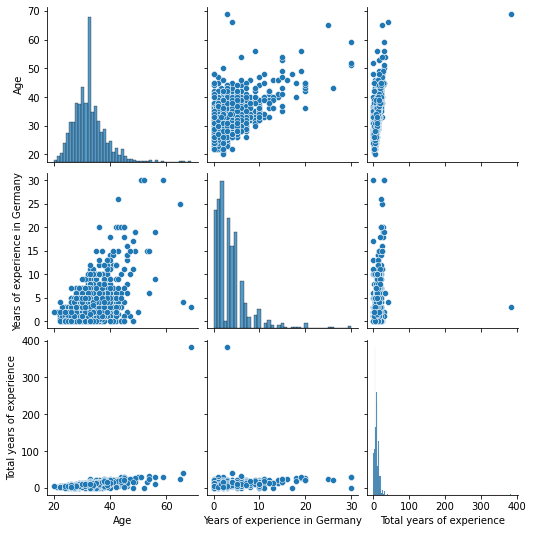

In [831]:
# See relationship and see outliers
sns.pairplot(df[['Age', 'Years of experience in Germany', 'Total years of experience']])

In [832]:
#Remove outliers
df = df[df['Age'] <= 65.0]

In [833]:
dfs = df.values

In [834]:
X = dfs[:, :-1]
y = dfs[:,-1]

In [835]:
X = X.astype(str)

In [836]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (838, 15) (838,)
Test (413, 15) (413,)


In [837]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# prepare input data
def prepare_inputs(X_train, X_test):
 oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
 oe.fit(X_train)
 X_train_enc = oe.transform(X_train)
 X_test_enc = oe.transform(X_test)
 return X_train_enc, X_test_enc
 
# prepare target
def prepare_targets(y_train, y_test):
 le = LabelEncoder()
 le.fit(y_train)
 y_train_enc = le.transform(y_train)
 y_test_enc = le.transform(y_test)
 return y_train_enc, y_test_enc

def select_features(X_train, y_train, X_test):
 fs = SelectKBest(score_func=chi2, k=4)
 fs.fit(X_train, y_train)
 X_train_fs = fs.transform(X_train)
 X_test_fs = fs.transform(X_test)
 return X_train_fs, X_test_fs
 

In [838]:
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
# feature selection
X_train_fs, X_test_fs = select_features(X_train_enc, y_train_enc, X_test_enc)


ValueError: y contains previously unseen labels: 174000.0

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# fit the model
model = LogisticRegression(solver='lbfgs')
model.fit(X_train_enc, y_train_enc)
# evaluate the model
yhat = model.predict(X_test_enc)
# evaluate predictions
accuracy = accuracy_score(y_test_enc, yhat)
print('Accuracy: %.2f' % (accuracy*100))

NameError: name 'y_train_enc' is not defined